## GloVe: Global Vectors 
This implementation is from this [paper](https://nlp.stanford.edu/pubs/glove.pdf). GloVe is designed to take advantage two primary families of learning word vectors, i.e. global matrix factorization methods (e.g. latent symantic analysis) and local context window based methods (e.g. skip-gram). Each has their own weaknes. Global methods do poor in word analogy tasks, i.e. a is to b as c is to _. But context window based methods do well in such tasks but fail to incorporate the global picture of things while doing so.

In [0]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
import tensorflow as tf
from scipy.sparse import lil_matrix

For this exercise I'll be using few code blocks and data from the google Deep Learning course, copied from 5_word2vec.ipynb. Download the dataset by running the code block below.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data from above to a string

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))
print('Sample string %s', words[:50])

Data size 17005207
Sample string %s ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term', 'is', 'still', 'used', 'in', 'a', 'pejorative', 'way', 'to', 'describe', 'any', 'act', 'that', 'used', 'violent', 'means', 'to', 'destroy', 'the']


Build the dataset. All the rare (infrequent) words are replaced with 'UNK' (index 0) token.

dictionary: word to index mapping

reverse_dictionary: index to word mapping

In [4]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


Generate batches of data and labels co-occurance weights. These weights denote how far the context word is from the target word.

In [5]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  weights = np.ndarray(shape=(batch_size), dtype=np.float32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
      weights[i * num_skips + j] = abs(1.0/(target - skip_window))
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels, weights

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (8, 4)]:
    data_index = 0
    batch, labels, weights = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])
    print('    weights:', [w for w in weights])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'originated', 'a', 'term', 'as', 'of', 'a']
    weights: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

with num_skips = 8 and skip_window = 4:
    batch: ['term', 'term', 'term', 'term', 'term', 'term', 'term', 'term']
    labels: ['originated', 'as', 'anarchism', 'first', 'of', 'used', 'a', 'abuse']
    weights: [0.33333334, 0.5, 0.25, 0.33333334, 1.0, 0.25, 1.0, 0.5]


## Creating the Word Co-Occurance Matrix
Why GloVe shine above context window based method is that it employs global statistics of the corpus in to the model (according to authors). This is done by using information from the word co-occurance matrix to optimize the word vectors. Basically, the X(i,j) entry of the co-occurance matrix says how frequent word i to appear near j. We also use a weighting mechanishm to give more weight to words close together than to ones further-apart (from experiments section of the paper).

In [6]:
# We are creating the co-occurance matrix as a compressed sparse colum matrix from scipy. 
# initially I was thinking of using SparseTensor (from tensorflow) however it's not well-devloped (cannot change individual elements)
cooc_data_index = 0
dataset_size = len(data)
skip_window = 4 # How many words to consider left and right.
num_skips = 8 # How many times to reuse an input to generate a label.
#dataset_size = 1000000 #used the value for test purposes
cooc_mat = lil_matrix((vocabulary_size, vocabulary_size), dtype=np.float32)
print(cooc_mat.shape)
def generate_cooc(batch_size,num_skips,skip_window):
    data_index = 0
    print('Running %d iterations to compute the co-occurance matrix'%(dataset_size//batch_size))
    for i in range(dataset_size//batch_size):
        if i>0 and i%100000==0:
            print('\tFinished %d iterations'%i)
        batch, labels, weights = generate_batch(batch_size=batch_size, num_skips=num_skips, skip_window=skip_window) # increments data_index automatically
        labels = labels.reshape(-1)
        
        for inp,lbl,w in zip(batch,labels,weights):            
            cooc_mat[inp,lbl] += (1.0*w)
            
generate_cooc(8,num_skips,skip_window)    

# just printing some parts of co-occurance matrix
print('Sample chunks of co-occurance matrix')
rand_target_idx = np.random.randint(0,vocabulary_size,10).tolist()
for i in range(10):
    idx_target = i
    ith_row = cooc_mat.getrow(idx_target) # get the ith row of the sparse matrix
    # couldn't use todense() but toarray() works
    # need to find the difference (welcome any reasoning behind this)
    ith_row_dense = ith_row.toarray('C').reshape(-1)        
    # select target words only with a reasonable words around it.
    while np.sum(ith_row_dense)<10 or np.sum(ith_row_dense)>50000:
        idx_target = np.random.randint(0,vocabulary_size)
        ith_row = cooc_mat.getrow(idx_target) # get the ith row of the sparse matrix
        ith_row_dense = ith_row.toarray('C').reshape(-1)    
        
    print('\nTarget Word: "%s"'%reverse_dictionary[idx_target])
        
    sort_indices = np.argsort(ith_row_dense).reshape(-1) # indices with highest count of ith_row_dense
    sort_indices = np.flip(sort_indices,axis=0) # reverse the array (to get max values to the start)

    # printing several context words to make sure cooc_mat is correct
    print('Context word:',end='')
    for j in range(10):        
        idx_context = sort_indices[j]       
        print('"%s"(id:%d,count:%.2f), '%(reverse_dictionary[idx_context],idx_context,ith_row_dense[idx_context]),end='')
    print()


(50000, 50000)
Running 2125650 iterations to compute the co-occurance matrix
	Finished 100000 iterations
	Finished 200000 iterations
	Finished 300000 iterations
	Finished 400000 iterations
	Finished 500000 iterations
	Finished 600000 iterations
	Finished 700000 iterations
	Finished 800000 iterations
	Finished 900000 iterations
	Finished 1000000 iterations
	Finished 1100000 iterations
	Finished 1200000 iterations
	Finished 1300000 iterations
	Finished 1400000 iterations
	Finished 1500000 iterations
	Finished 1600000 iterations
	Finished 1700000 iterations
	Finished 1800000 iterations
	Finished 1900000 iterations
	Finished 2000000 iterations
	Finished 2100000 iterations
Sample chunks of co-occurance matrix

Target Word: "yster"
Context word:"cult"(id:2584,count:3.00), "blue"(id:759,count:3.00), "official"(id:314,count:0.50), "group"(id:189,count:0.50), "seven"(id:23,count:0.50), "came"(id:422,count:0.50), "discography"(id:6597,count:0.50), "whiskey"(id:17847,count:0.50), "pdf"(id:2831,co

## Defining the Loss function with Tensorflow
This is the main contribution of the paper. Loss function derivation can be found in the paper and well-explained. So I'm not going to dive into the theoritical riff-raff, but focus on the implementation itself. 

In [7]:
batch_size = 128
embedding_size = 192 # Dimension of the embedding vector.

# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.

# Validation set consist of 50 infrequent words and 50 frequent words
valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
valid_examples = np.append(valid_examples,random.sample(range(1000,1000+valid_window), valid_size//2))

epsilon = 1 # used for the stability of log in the loss function
graph = tf.Graph()

#with graph.as_default(), tf.device('/cpu:0'):

# Input data.
train_dataset = tf.placeholder(tf.int32, shape=[batch_size],name='train_dataset')
train_labels = tf.placeholder(tf.int32, shape=[batch_size],name='train_labels')
valid_dataset = tf.constant(valid_examples, dtype=tf.int32,name='valid_dataset')

# Variables.
embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0),name='embeddings')
bias_embeddings = tf.Variable(tf.random_uniform([vocabulary_size],0.0,0.01,dtype=tf.float32),name='embeddings_bias')

# Model.
# Look up embeddings for inputs.
embed_in = tf.nn.embedding_lookup(embeddings, train_dataset)
embed_out = tf.nn.embedding_lookup(embeddings, train_labels)
embed_bias_in = tf.nn.embedding_lookup(bias_embeddings,train_dataset)
embed_bias_out = tf.nn.embedding_lookup(bias_embeddings,train_labels)

# weights used in the cost function
weights_x = tf.placeholder(tf.float32,shape=[batch_size],name='weights_x') 
x_ij = tf.placeholder(tf.float32,shape=[batch_size],name='x_ij')

# Compute the loss defined in the paper. Note that I'm not following the exact equation given (which is computing a pair of words at a time)
# I'm calculating the loss for a batch at one time, but the calculations are identical.
# I also made an assumption about the bias, that it is a smaller type of embedding
loss = tf.reduce_mean(
    weights_x * (tf.reduce_sum(embed_in*embed_out,axis=1) + embed_bias_in + embed_bias_out - tf.log(epsilon+x_ij))**2)

# Optimizer.
# Note: The optimizer will optimize the softmax_weights AND the embeddings.
# This is because the embeddings are defined as a variable quantity and the
# optimizer's `minimize` method will by default modify all variable quantities 
# that contribute to the tensor it is passed.
# See docs on `tf.train.Optimizer.minimize()` for more details.
optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

# Compute the similarity between minibatch examples and all embeddings.
# We use the cosine distance:
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(
normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
keep_dims is deprecated, use keepdims instead


## Running GloVe
I'm going to use the downloaded dataset to test GloVe. If the algorithm runs correctly, you should see target words having similar words as their closest neighbors. And obviously the error should decrease.

In [8]:
num_steps = 100001

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

print('Initialized')
average_loss = 0
for step in range(num_steps):
    batch_data, batch_labels, batch_weights = generate_batch(
        batch_size, num_skips, skip_window) # generate a single batch (data,labels,co-occurance weights)
    batch_weights = [] # weighting used in the loss function
    batch_xij = [] # weighted frequency of finding i near j
    for inp,lbl in zip(batch_data,batch_labels.reshape(-1)):        
        batch_weights.append((np.asscalar(cooc_mat[inp,lbl])/100.0)**0.75)
        batch_xij.append(cooc_mat[inp,lbl])
    batch_weights = np.clip(batch_weights,-100,1)
    batch_xij = np.asarray(batch_xij)

    feed_dict = {train_dataset : batch_data.reshape(-1), train_labels : batch_labels.reshape(-1),
                weights_x:batch_weights,x_ij:batch_xij}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)

    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
final_embeddings = normalized_embeddings.eval()



Initialized
Average loss at step 0: 23.058765
Nearest to called: engage, surrey, atlantic, lipschitz, reforms, dayan, begins, oup,
Nearest to states: nipples, fringing, bungee, catalyse, montoya, emf, tis, wanderer,
Nearest to united: adys, useable, targeting, kab, instilled, atiyah, outfielder, huygens,
Nearest to that: thebes, micro, asis, ki, nils, restyled, redactor, desires,
Nearest to their: season, permafrost, propane, boito, replace, catchphrase, electrolytic, senna,
Nearest to often: a, are, chipset, this, as, senna, racecourse, witnessed,
Nearest to also: doppelbock, handball, militarist, fukuyama, demons, anno, cumbria, elementals,
Nearest to eight: worcestershire, cmyk, values, apteryx, vivant, mcgrath, stoiber, emir,
Nearest to issue: sister, rescuers, cheryl, bead, rosso, minneapolis, antioxidants, imp,
Nearest to pre: astute, marred, burton, psc, apprenticeship, fewest, tm, truer,
Nearest to bbc: loyalist, observation, anhui, lar, yogic, malvern, wounded, diagnose,
Neare

## Visualization with T-SNE
Now let's visualize the word space to see what it's like. We plot two plots. You should see that similar words tend to clust
1. Frequent words
2. Slightly rare words


In [0]:
num_points = 1000
offset = 1000
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings_1 = tsne.fit_transform(final_embeddings[1:(num_points//2)+1,:])
two_d_embeddings_2 = tsne.fit_transform(final_embeddings[offset:offset+(num_points//2), :])

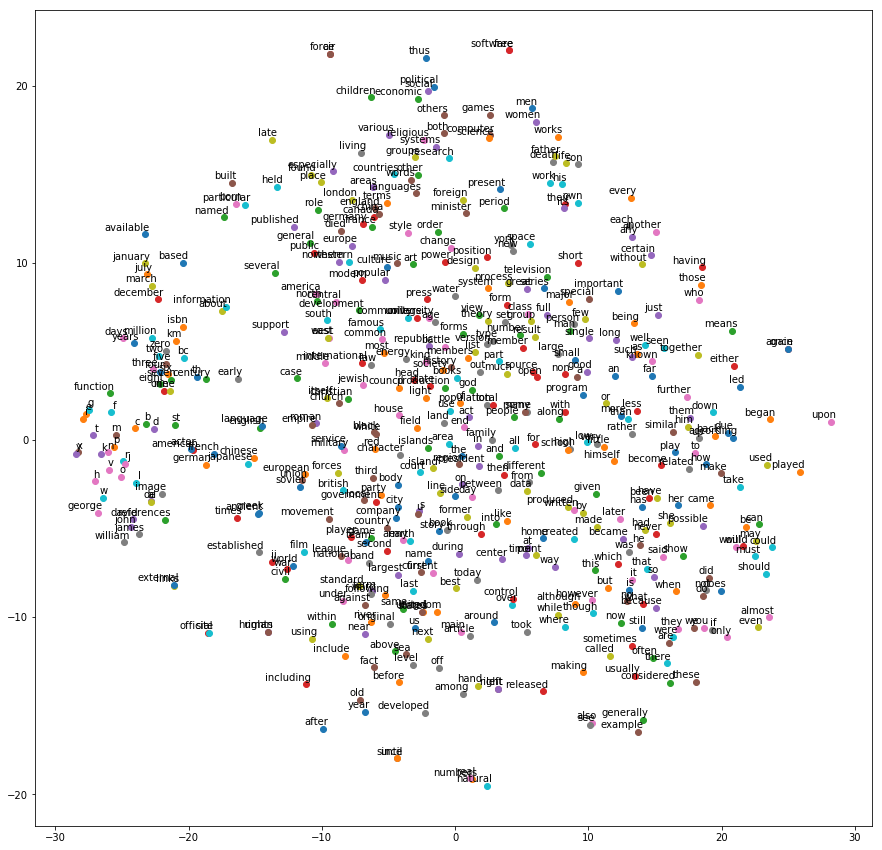

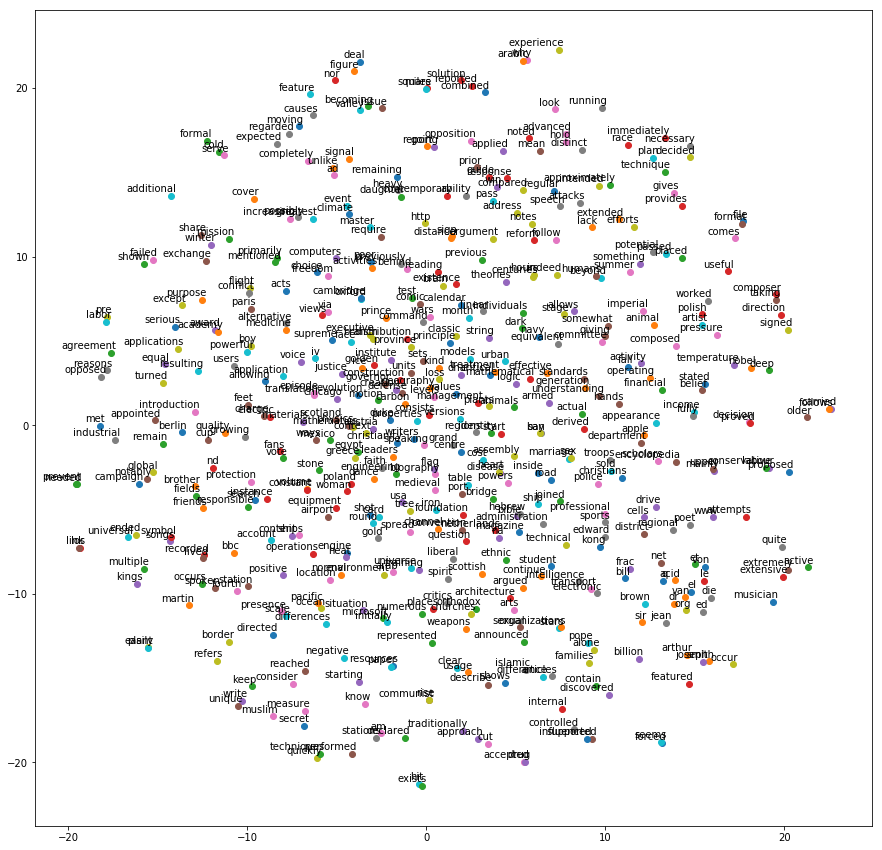

In [10]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words_1 = [reverse_dictionary[i] for i in range(1, (num_points//2)+1)]
words_2 = [reverse_dictionary[i] for i in range(offset, offset + (num_points//2))]

plot(two_d_embeddings_1, words_1)
plot(two_d_embeddings_2, words_2)